# Problem 2: Generative Adversarial Networks

* **Learning Objective:** In this problem, you will implement a Generative Adversarial Network with the network structure proposed in [*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434), and learn a visualization technique, *activation maximization*.
* **Provided code:** The code for constructing the two parts of the GAN, the discriminator and the generator, is done for you, along with the skeleton code for the training.
* **TODOs:** You will need to figure out how to properly feed the data, compute the loss and update the parameters to complete the training and visualization. In addition, to test your understanding, you will answer some non-coding questions.

In [8]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction: The forger versus the police

*Note: read the story even if you are already familiar with GANs, as one of the questions is related to this story.*

Generative models try to model the distribution of the data in an explicit way, in the sense that we can easily sample new data points from this model. This is in contrast to discriminative models that try to infer the output from the input. In the class we have seen one classic deep generative model, the Variational Autoencoder (VAE). Here, we will learn another generative model that has risen to prominence in recent years, the Generative Adversarial Network (GAN).

As the maths of Generative Adversarial Networks is somewhat tedious, a story is often told of a forger and a police to illustrate the idea.

> Imagine a forger that makes fake bills, and a police that tries to find these forgeries. If the forger were a VAE, his goal would be to take some real bills, and try to replicate the real bills as precisely as possible. In GAN, he has a different idea in his mind: rather than trying to replicate the real bills, it suffices to make fake bills such that people *think* they are real.
> 
> Now lets start. In the beginning, the police knows nothing about how to distinguish between real and fake bills. The forger knows nothing either and only produces white paper.
> 
> In the first round, the police gets the fake bill and learns that the forgeries are white while the real bills are green. The forger then finds out that white papers can no longer fool the police and starts to produce green papers.
>
> In the second round, the police learns that real bills have denominations printed on them while the forgeries do not. The forger then finds out that plain papers can no longer fool the police and starts to print numbers on them.
>
> In the third round, the police learns that real bills have watermarks on them while the forgeries do not. The forger then has to reproduce the watermarks on his fake bills.
>
> ...
>
> Finally, the police is able to spot the tiniest difference between real and fake bills and the forger has to make perfect replicas of real bills to fool the police.

Now in a GAN, the forger becomes the generator and the police becomes the discriminator. The discriminator is a binary classifier with the two classes being "taken from the real data" ("real") and "generated by the generator" ("fake"). Its objective is to minimize the classification loss. The generator's objective is to generate samples so that the discriminator misclassify them as real.

Here we have some complications: the goal is not to find one perfect fake sample. Such a sample will not actually fool the discriminator: if the forger makes hundreds of the exact same fake bill, they will all have the same serial number and the police will soon find out that they are fake. Instead, we want the generator to be able to generate a variety of fake samples such that when presented as a distribution alongside the distribution of real samples, these two are indistinguishable by the discriminator.

So how do we generate different samples with a diterministic generator? We provide it with random numbers as input.

Typically, for the discriminator we use binary cross entropy loss with label 1 being real and 0 being fake. For the generator, the input is a random vector drawn from a standard normal distribution. Denote the generator by $G_{\phi}(z)$, discriminator by $D_{\theta}(x)$, the distribution of the real samples by $p(x)$ and the input distribution to the generator by $q(z)$. Recall that the binary cross entropy loss with classifier output $y$ and label $\hat{y}$ is

$$L(y, \hat{y}) = -\hat{y} \log y - (1 - \hat{y}) \log (1 - y)$$

For the discriminator, the objective is

$$\min_{\theta} \mathrm{E}_{x \sim p(x)}[L(D_{\theta}(x), 1)] + \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

For the generator, the objective is

$$\max_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

The generator's objective corresponds to maximizing the classification loss of the discriminator on the generated samples. Alternatively, we can **minimize** the classification loss of the discriminator on the generated samples  **when labelled as real**:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

And this is what we will use in our implementation. The strength of the two networks should be balanced, so we train the two networks alternatingly, updating the parameters in both networks once in each interation.

## Problem 2-1: Implementing the GAN

We first load the data (CIFAR-10) and define some convenient functions. You should already have CIFAR-10 from assignment 1. Just copy the data from there or use ```data/get_datasets.sh``` if you don't have them.

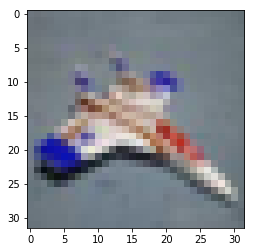

In [9]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples = load_test_data() / 255.0

cifar10ToUse = train_samples[30]
cifar10ToUse= cifar10ToUse[...,::-1]
plt.imshow(cifar10ToUse)

In [10]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

To save you some mundane work, we have defined a discriminator and a generator for you, in ```_discriminator()``` and ```_generator()``` respectively. Look at the code to see what layers are there.

For this part, you need to complete code blocks marked with "Prob 2-1":

*   **Build the computation graph for the losses:** Complete the following definitions in ```_init_ops()```
    *   ```fake_samples_op```: generate famples from ```noise```
    *   ```dis_loss_op```: compute discriminator's loss, with real samples from ```real_input``` and fake
        samples generated by the generator
    *   ```gen_loss_op```: compute generator's loss
*   **Define the optimizer:** We use RMSprop for training. Adam is observed to perform poorly with an unstable objective as is the case in GANs. We've defined ```dis_train_op``` and ```gen_train_op``` for you but those are wrong: rather than updating all the parameters all the time, when training one network we want to keep the other one fixed. Modify the definition to reflect this. [Check here](https://stackoverflow.com/a/35304001) if you are not sure how this is possible.
*   **Feed the data:** Feed the proper samples and labels in ```train()``` for training and in ```generate_one_sample()``` for visualizing the generated samples.

The batch normalization layers should operate in training mode. As per *[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)*, we put real samples and fake samples in different batches when training the discriminator.

*Note: use the advices on that page with caution if you are doing GAN for your team project. It is already 10 months old, which is a **really long time** in deep learning research. It does not reflect the latest results.*

In [14]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64 # this is like z-dimension
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 200
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size]) 
        # z-placeholder (batch_size(None), z-dim(self.code_size))
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        # fake_samples_op: generate famples from noise
        # dis_loss_op: compute discriminator's loss, 
        #              with real samples from real_input and fake samples generated by the generator
        # gen_loss_op: compute generator's loss
        """
        self.G = self.generator(self.z)
        self.D, self.D_logits = self.discriminator(self.images)
        self.D_, self.D_logits_ = self.discriminator(self.G, reuse=True)
        """
        # setting the model
        self.fake_samples_op = self._generator(self.noise)        
        dis_real_logits = self._discriminator(self.real_input)
        dis_real_prob = tf.nn.sigmoid(dis_real_logits)
        dis_fake_logits = self._discriminator(self.fake_samples_op)
        dis_fake_prob = tf.nn.sigmoid(dis_fake_logits)

        dis_real_logits = self._discriminator(self.real_input)
        dis_fake_logits = self._discriminator(self.fake_samples_op)
        # fake & real loss
        #dis_fake_loss = self._loss(logits=dis_fake_logits, labels=tf.ones_like(dis_fake_logits))
        dis_fake_loss = self._loss(logits=dis_fake_logits, labels=self.fake_label)
        # dis_real_loss = self._loss(logits=dis_real_logits, labels=tf.zeros_like(dis_real_logits))
        dis_real_loss = self._loss(logits=dis_real_logits, labels=self.real_label)
        
        # total loss
        self.dis_loss_op = dis_fake_loss + dis_real_loss
        #self.gen_loss_op = self._loss(logits=dis_fake_logits, labels=tf.ones_like(dis_fake_logits))
        self.gen_loss_op = self._loss(logits=dis_fake_logits, labels=self.real_label)
        
        #self.dis_loss_op = self._loss(logits=D_logit_real, labels=tf.ones_like(D_logit_real) tf.ones_like(Dx),)
        #self.gen_loss_op = self._loss(,)
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################

        # for freeze the vars when the opposite training
        #tvar = tf.trainable_variables()
        #dvar = [var for var in tvar if 'dis' in var.name]
        #gvar = [var for var in tvar if 'gen' in var.name]
        dvar = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gvar = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, var_list=dvar)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list=gvar)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        #self.recon_sample = self.reconstruct(np.random.normal(0, 1, [self.batch_size, self.code_size]))
        #self.recon_loss_op = self._loss(logits=self.recon_sample, labels=self.actmax_label)        
        #recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        #self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op)

        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                dis_feed_dict = {self.real_input: batch_samples, self.real_label: ones, self.fake_label: zeros,
                                 self.noise: noise, self.is_train: True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                #gen_feed_dict = {self.real_input: batch_samples, self.real_label: ones, self.fake_label: zeros,
                #                 self.noise: noise, self.is_train: True}
                gen_feed_dict = {self.real_label: ones, self.noise: noise, self.is_train: True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        # put an initial code in to actmax_init_val
        actmax_init_val = tf.convert_to_tensor(np.random.random([1, self.code_size]), dtype = tf.float32)
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################
                
            #recon_feed_dict = {self.recon_sample: self.actmax_code, self.actmax_label: np.ones([1, 1]), 
            #                   self.is_train: False}
            
            recon_feed_dict = {self.recon_sample: sample, self.is_train: False}
        
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################

        gen_vis_feed_dict = {self.noise: code, self.is_train: False}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

Now let's do the training!

Non't panic if the loss curve goes wild. The two networks are competing for the loss curve to go different directions, so virtually anything can happen. If your code is correct, the generated samples should have a high variety.

Iteration 50: dis loss = 0.4666, gen loss = 2.0871
Iteration 100: dis loss = 0.0829, gen loss = 3.9223
Iteration 150: dis loss = 0.1368, gen loss = 4.7081
Iteration 200: dis loss = 0.1006, gen loss = 3.5317
Iteration 250: dis loss = 0.0329, gen loss = 4.2363
Iteration 300: dis loss = 1.0061, gen loss = 0.7132
Iteration 350: dis loss = 0.3535, gen loss = 2.0612
Iteration 400: dis loss = 0.8554, gen loss = 1.1533
Iteration 450: dis loss = 0.6400, gen loss = 1.4492
Iteration 500: dis loss = 0.7007, gen loss = 2.2269
Iteration 550: dis loss = 0.7600, gen loss = 1.6771
Iteration 600: dis loss = 0.5503, gen loss = 1.6998
Iteration 650: dis loss = 0.6843, gen loss = 1.2976
Iteration 700: dis loss = 0.6167, gen loss = 3.0415
Iteration 750: dis loss = 0.4493, gen loss = 2.4221
Iteration 800: dis loss = 0.3166, gen loss = 2.5778
Iteration 850: dis loss = 0.5966, gen loss = 1.4055
Iteration 900: dis loss = 1.1122, gen loss = 0.4794
Iteration 950: dis loss = 0.7598, gen loss = 2.1931
Iteration 100

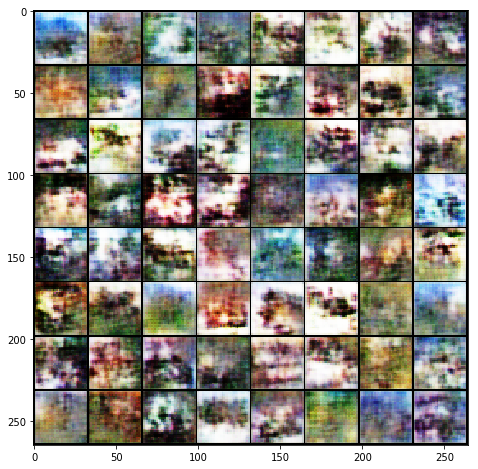

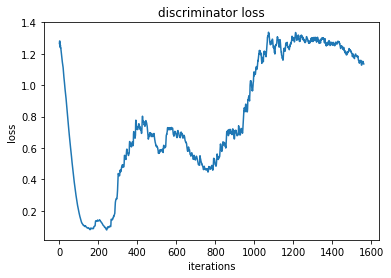

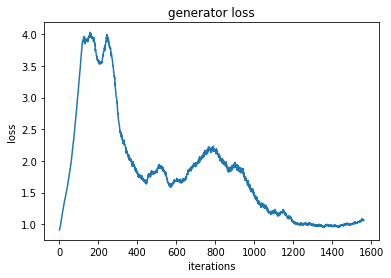

Iteration 1600: dis loss = 1.0742, gen loss = 1.3204
Iteration 1650: dis loss = 0.9714, gen loss = 1.2533
Iteration 1700: dis loss = 1.1078, gen loss = 1.1996
Iteration 1750: dis loss = 1.0639, gen loss = 1.1337
Iteration 1800: dis loss = 1.2291, gen loss = 0.8039
Iteration 1850: dis loss = 1.2774, gen loss = 1.3798
Iteration 1900: dis loss = 1.3196, gen loss = 1.4705
Iteration 1950: dis loss = 1.1721, gen loss = 1.1566
Iteration 2000: dis loss = 1.0266, gen loss = 1.0794
Iteration 2050: dis loss = 1.2851, gen loss = 0.7620
Iteration 2100: dis loss = 1.2922, gen loss = 0.7157
Iteration 2150: dis loss = 1.3105, gen loss = 0.7179
Iteration 2200: dis loss = 1.2109, gen loss = 0.8449
Iteration 2250: dis loss = 1.2781, gen loss = 1.2523
Iteration 2300: dis loss = 1.2040, gen loss = 0.7066
Iteration 2350: dis loss = 1.0612, gen loss = 0.9878
Iteration 2400: dis loss = 1.1388, gen loss = 1.3868
Iteration 2450: dis loss = 1.1714, gen loss = 1.4449
Iteration 2500: dis loss = 1.1552, gen loss = 

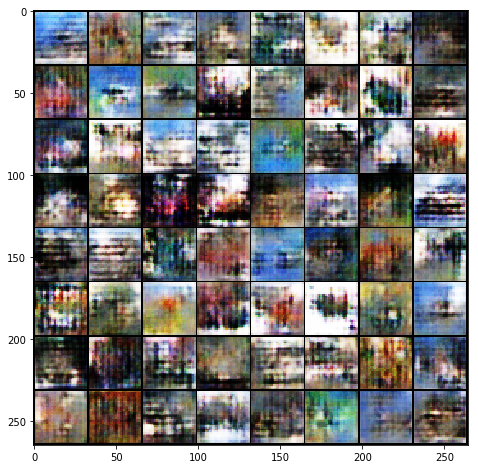

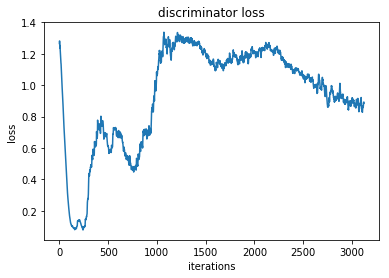

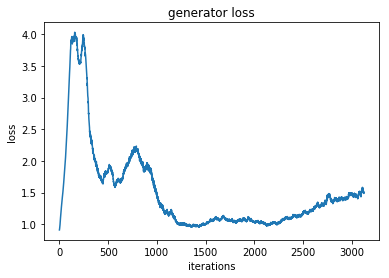

Iteration 3150: dis loss = 0.9537, gen loss = 1.7146
Iteration 3200: dis loss = 0.8132, gen loss = 0.7950
Iteration 3250: dis loss = 0.6743, gen loss = 1.2731
Iteration 3300: dis loss = 1.0266, gen loss = 0.9777
Iteration 3350: dis loss = 0.9190, gen loss = 0.8170
Iteration 3400: dis loss = 1.1287, gen loss = 2.3217
Iteration 3450: dis loss = 0.6212, gen loss = 1.3638
Iteration 3500: dis loss = 1.0293, gen loss = 0.7689
Iteration 3550: dis loss = 0.8552, gen loss = 2.0896
Iteration 3600: dis loss = 0.8506, gen loss = 1.2378
Iteration 3650: dis loss = 0.9401, gen loss = 0.7822
Iteration 3700: dis loss = 1.0213, gen loss = 1.5330
Iteration 3750: dis loss = 0.8694, gen loss = 1.8721
Iteration 3800: dis loss = 0.9496, gen loss = 1.6195
Iteration 3850: dis loss = 0.7514, gen loss = 1.3688
Iteration 3900: dis loss = 0.6495, gen loss = 1.4972
Iteration 3950: dis loss = 1.1095, gen loss = 0.7551
Iteration 4000: dis loss = 0.7803, gen loss = 1.8227
Iteration 4050: dis loss = 0.8720, gen loss = 

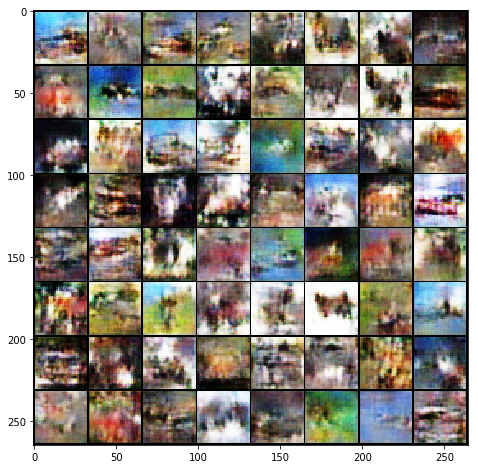

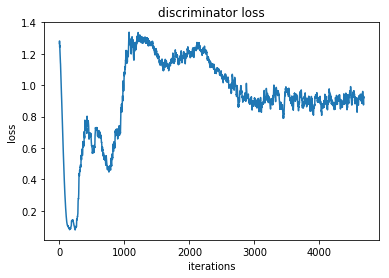

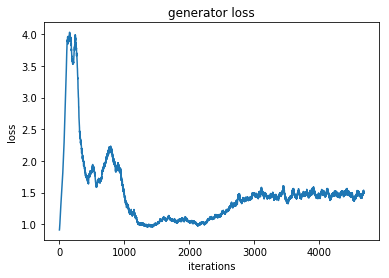

Iteration 4700: dis loss = 0.9666, gen loss = 2.4419
Iteration 4750: dis loss = 0.7937, gen loss = 1.1374
Iteration 4800: dis loss = 1.1206, gen loss = 2.1535
Iteration 4850: dis loss = 0.5804, gen loss = 1.4010
Iteration 4900: dis loss = 0.9304, gen loss = 0.8295
Iteration 4950: dis loss = 0.7718, gen loss = 1.7155
Iteration 5000: dis loss = 1.0183, gen loss = 2.1703
Iteration 5050: dis loss = 1.0165, gen loss = 0.7474
Iteration 5100: dis loss = 0.6954, gen loss = 2.0445
Iteration 5150: dis loss = 0.9370, gen loss = 1.0699
Iteration 5200: dis loss = 1.0420, gen loss = 2.2300
Iteration 5250: dis loss = 0.7106, gen loss = 1.2479
Iteration 5300: dis loss = 0.9054, gen loss = 0.9461
Iteration 5350: dis loss = 0.8586, gen loss = 2.0746
Iteration 5400: dis loss = 0.5441, gen loss = 1.2215
Iteration 5450: dis loss = 0.8415, gen loss = 2.4413
Iteration 5500: dis loss = 0.7843, gen loss = 1.4405
Iteration 5550: dis loss = 0.9001, gen loss = 0.8439
Iteration 5600: dis loss = 0.8177, gen loss = 

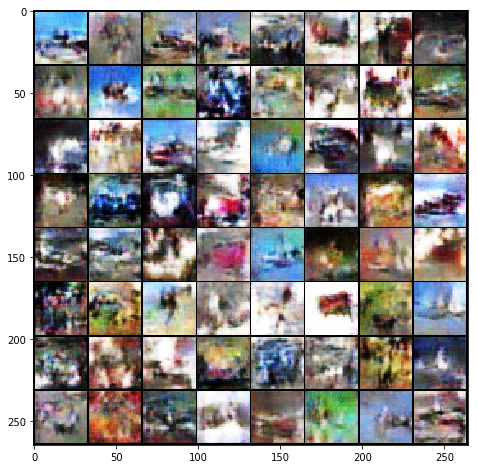

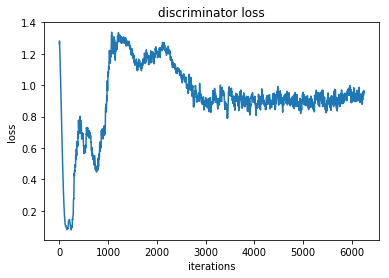

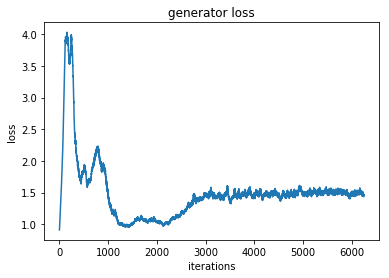

Iteration 6250: dis loss = 0.9583, gen loss = 0.9256
Iteration 6300: dis loss = 1.1819, gen loss = 0.9490
Iteration 6350: dis loss = 0.8772, gen loss = 0.8797
Iteration 6400: dis loss = 0.9391, gen loss = 1.8221
Iteration 6450: dis loss = 0.5087, gen loss = 1.7003
Iteration 6500: dis loss = 0.8523, gen loss = 1.0783
Iteration 6550: dis loss = 0.9261, gen loss = 1.8245
Iteration 6600: dis loss = 1.2755, gen loss = 0.5934
Iteration 6650: dis loss = 0.9545, gen loss = 1.8539
Iteration 6700: dis loss = 0.8798, gen loss = 2.1935
Iteration 6750: dis loss = 0.9004, gen loss = 0.9662
Iteration 6800: dis loss = 0.8340, gen loss = 1.5250
Iteration 6850: dis loss = 0.8601, gen loss = 1.0595
Iteration 6900: dis loss = 1.2095, gen loss = 2.1826
Iteration 6950: dis loss = 0.8417, gen loss = 1.9435
Iteration 7000: dis loss = 0.7285, gen loss = 1.5120
Iteration 7050: dis loss = 0.9024, gen loss = 0.8045
Iteration 7100: dis loss = 0.8123, gen loss = 1.8549
Iteration 7150: dis loss = 1.0086, gen loss = 

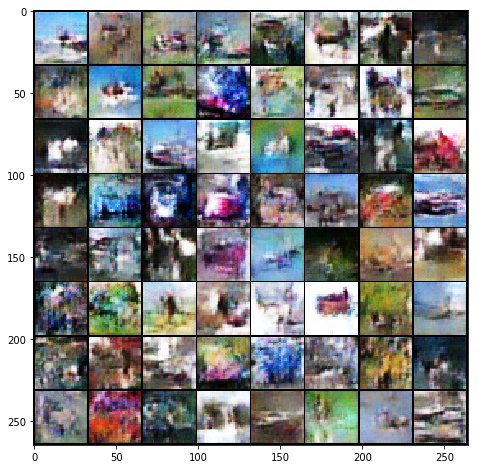

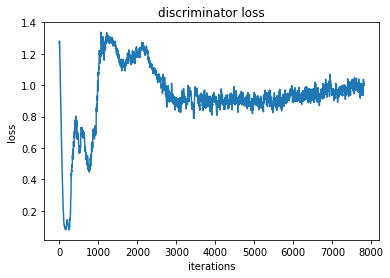

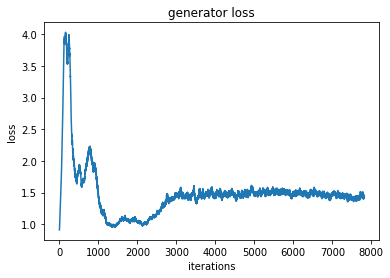

In [26]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')


## Problem 2-2: The forger versus the police, revisited

In the forger versus police story, we made part of it hand-wavy to hide a flaw that makes the story improbable to actually happen and makes it a bad analogy of how the training works in a GAN. Now that you have implemented a GAN, can you spot the flaw?

Specifically, when we consider one of the two parties, the other is treated as a black box. They know their opponent's result but not how they works. What is wrong here?

**Your answer below:**

Actually, even the other party is treated as a black box, when we trained the model, we still need to know the variables from the other side, for example, calculate dis_fake_loss is involved generator(z).

In real story, we cannot know how the loss diffrence and don't have the way to do how to minimize the loss.

---

*The Tao of GANs: They might be adversaries, yet they are also cooperative.*

---

## Problem 2-3: The Batch Normalization dilemma

Here are three questions related to the use of Batch Normalization in GANs. The first two will not be graded and their answers are provided. But you should attempt to solve them before looking at the answer.

---

We made separate batches for real samples and fake samples when training the discriminator. Is this just an arbitrary design decision made by the inventor that later becomes the common practice, or is it critical to the correctness of the algorithm?

**Select text below to see answer:**

<p style="color:black;">When we are training the generator, the input batch to the discriminator will always consist of only fake samples. If we separate real and fake batches when training the discriminator, then the fake samples are normalized in the same way when we are training the discriminator and when we are training the generator. If we mix real and fake samples in the same batch when training the discriminator, then the fake samples are not normalized in the same way when we train the two networks, which causes the generator to fail to learn the correct distribution.</p>

---

Look at the construction of the discriminator carefully. You will find that between ```dis_conv1``` and ```dis_lrelu1``` there is no batch normalization. This is not a mistake. What could go wrong if there were a batch normalization layer there? Why do you think that omitting this batch normalization layer solves the problem practically if not theoretically?

**Select text below to see answer:**

<p style="color:black;">Since we put real samples and fake samples in separate batches, if we add a batch normalization layer between dis_conv1 and dis_lrelu1, the discriminator would not be able to distinguish two distributions if one can be obtained by applying an isotropic scaling and a translation in color space to the other.</p>

<p style="color:black;">By removing the first batch normalization layer, for two different distributions to get confused with each other they must produce two distributions after dis_lrelu1 such that one can be obtained by applying an isotropic scaling and a translation to the other. Such a case is still possible but extremely unlikely to happen.</p>

---

Propose a different way of feeding the samples to solve the problem in the second question without omitting any batch normalization layers or changing their mode of operation.

**Your answer below:**

Using dropout to feed the samples.

---

*Take-aways from this problem: always excercise extreme caution when using batch normalization in your network!*

*Advertisement: read the TA's paper to find out more about why Batch Normalization might be bad for your GANs: [On the Effects of Batch and Weight Normalization in Generative Adversarial Networks](https://arxiv.org/abs/1704.03971)*

---

## Problem 2-4: Activation Maximization

Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to *[Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://arxiv.org/abs/1605.09304)*.

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code.

The batch normalization layers should work in evaluation mode.

We provide the code for this part, as a reference for solving the next part. You may want to go back to the code above and check the following:

*   **Build the computation graph for the loss:** Check the definition of these operations in ```_init_ops()```
    *   ```actmax_sample_op```: generate famples from ```actmax_code```
    *   ```actmax_loss_op```: compute discriminator's loss on samples generated from ```actmax_code```
*   **Define the optimizer:** Check the definition of ```actmax_op```, which updates ```actmax_code```
*   **Feed the data:** Check the function ```actmax_one_sample()```

INFO:tensorflow:Restoring parameters from model/dcgan


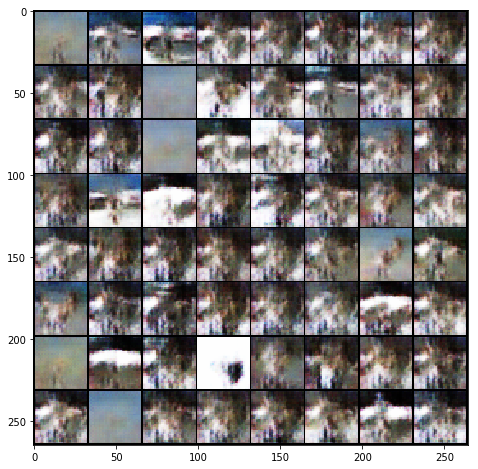

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

The output should have less variety than those generated from random code. While it is reasonable that the samples that are "most real" makes up only a small portion of the sample space, this also gives us a hint that the so-called "mode collapse", in which the GAN simply fails to model a majority part of the data distribution, is a real problem.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the terget image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.

For this part, you need to complete code blocks marked with "Prob 2-4":

*   **Build the computation graph for the loss:** Complete the definition of ```recon_loss_op``` in ```_init_ops()```, which computes the squared L2-distance between ```recon_sample``` and the sample generated from ```actmax_code```.
*   **Define the optimizer:** Modify the definition of ```reconstruct_op``` so that it updates ```actmax_code``` rather than the parameters of the networks.
*   **Feed the data:** Set the proper initial value and feed the proper data in ```reconstruct_one_sample()```

INFO:tensorflow:Restoring parameters from model/dcgan
average reconstruction loss = 30.7622


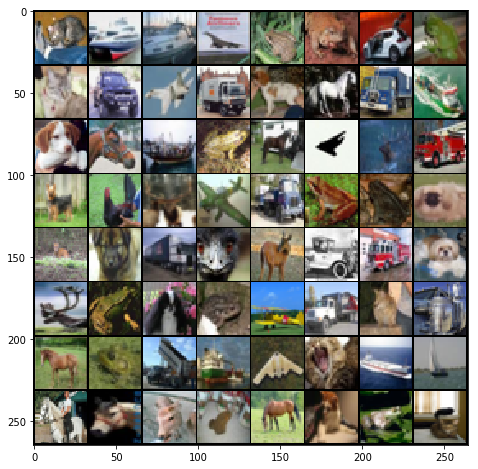

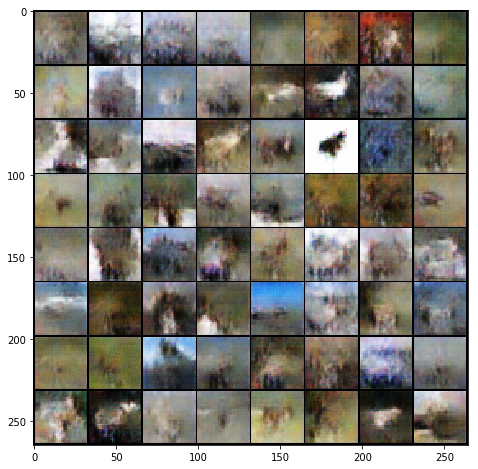

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(test_samples[0:64], 1))
        plt.show()
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(reconstructions, 1))
        plt.show()

Now you can increase the training epochs. You should be able to achieve a reconstruction loss lower than 30.